In [1]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

import tf_lab.point_clouds.in_out as pio
import tf_lab.models.point_net_based_AE as pnAE

from tf_lab.fundamentals.utils import set_visible_GPUs

from tf_lab.point_clouds.in_out import PointCloudDataSet
from tf_lab.point_clouds.vae import VariationalAutoencoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf
import tf_lab.point_clouds.various_encoders_decoders as enc_dec
from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id, match_incomplete_to_complete_data

from tf_lab.autopredictors.evaluate.basics import eval_model, read_saved_epochs
from tf_lab.autopredictors.plotting.basics import plot_original_pclouds_vs_reconstructed,\
                                                  plot_train_val_test_curves, plot_reconstructions_at_epoch


from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs
from geo_tool import Point_Cloud

/orions4-zfs/projects/lins2/Panos_Space/Git_Repos/geo_tool/solids/mesh.py:26: UserWarning: Mayavi library was not found. Some graphics utilities will be disabled.
  warnings.warn('Mayavi library was not found. Some graphics utilities will be disabled.')


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [17]:
class_type = raw_input('Give me the class type.\n').lower()
class_syn_id = shape_net_category_to_synth_id()[class_type]
experiment_name = 'emd_full_shapes_' + class_syn_id + '_vae_z30'

seed = 42
np.random.seed(seed)
tf.set_random_seed(seed)

top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'
full_pclouds_path = osp.join(top_data_dir, 'ShapeNetPointClouds/from_manifold_meshes/1024/', class_syn_id)

train_dir = osp.join(top_data_dir, 'OUT/models/variational')
train_dir = osp.join(train_dir, experiment_name)
create_dir(train_dir)

Give me the class type.
chair


'/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/variational/emd_full_shapes_03001627_vae_z30'

In [4]:
full_file_names = pio.load_filenames_of_input_data(full_pclouds_path)
full_pclouds, full_model_names, class_ids = pio.load_crude_point_clouds(file_names=full_file_names, n_threads=15)
print '%d files containing complete point clouds were found.' % (len(full_pclouds), )

6778 files containing complete point clouds were found.


In [18]:
train_data_, val_data_, test_data_ = pio.train_validate_test_split([full_pclouds, 
                                                                    full_model_names],
                                                                    train_perc=0.95,
                                                                    validate_perc=0.0,
                                                                    test_perc=0.05,                                                                   
                                                                    seed=seed)

train_data = PointCloudDataSet(train_data_[0], labels=train_data_[1])
test_data = PointCloudDataSet(test_data_[0], labels=test_data_[1])

In [19]:
def reset_graph():
    if 'sess' in globals() and sess:
        sess.close()
    tf.reset_default_graph()

set_visible_GPUs([3])

conf = Conf(n_input = [1024, 3],
            training_epochs = 1000,
            batch_size = 50,
            loss = 'chamfer',
            train_dir = train_dir,
            loss_display_step = 1,
            saver_step = 5,
            learning_rate = 0.0001,
            saver_max_to_keep = 200,
            gauss_augment = {'mu': 0, 'sigma': 0.02},
            encoder = enc_dec.encoder_1dcovnv_5_points,
            decoder = enc_dec.decoder_only_with_fc,
            spatial_trans = True,
            denoising = False,
            n_z = 30,
            latent_vs_recon = 0.5,
            z_rotate = True
           )

reset_graph()
vae = VariationalAutoencoder(experiment_name, conf)
vae.train(train_data, conf)

('Epoch:', '0001', 'training time (minutes)=', '0.1158', 'loss=', '416.630706310')
('Epoch:', '0002', 'training time (minutes)=', '0.1114', 'loss=', '388.267337084')
('Epoch:', '0003', 'training time (minutes)=', '0.1125', 'loss=', '370.890308857')
('Epoch:', '0004', 'training time (minutes)=', '0.1131', 'loss=', '358.666646242')
('Epoch:', '0005', 'training time (minutes)=', '0.1134', 'loss=', '340.737795472')
('Epoch:', '0006', 'training time (minutes)=', '0.1133', 'loss=', '324.473796487')
('Epoch:', '0007', 'training time (minutes)=', '0.1143', 'loss=', '319.544562101')
('Epoch:', '0008', 'training time (minutes)=', '0.1124', 'loss=', '303.927815914')
('Epoch:', '0009', 'training time (minutes)=', '0.1129', 'loss=', '287.298251033')
('Epoch:', '0010', 'training time (minutes)=', '0.1138', 'loss=', '276.182674289')
('Epoch:', '0011', 'training time (minutes)=', '0.1141', 'loss=', '257.342036963')
('Epoch:', '0012', 'training time (minutes)=', '0.1129', 'loss=', '247.480473518')
('Ep

[(1, 416.63070631027222, 6.94605016708374),
 (2, 388.26733708381653, 6.686814069747925),
 (3, 370.89030885696411, 6.747509002685547),
 (4, 358.66664624214172, 6.788899183273315),
 (5, 340.73779547214508, 6.803163051605225),
 (6, 324.47379648685455, 6.795462131500244),
 (7, 319.54456210136414, 6.856729030609131),
 (8, 303.92781591415405, 6.746766090393066),
 (9, 287.29825103282928, 6.774319887161255),
 (10, 276.18267428874969, 6.827661991119385),
 (11, 257.34203696250916, 6.8433308601379395),
 (12, 247.48047351837158, 6.772078990936279),
 (13, 242.28812408447266, 6.732836008071899),
 (14, 236.26012194156647, 6.829020977020264),
 (15, 226.29051697254181, 6.6873860359191895),
 (16, 219.54562973976135, 6.8592209815979),
 (17, 209.04949402809143, 6.8334739208221436),
 (18, 202.8170245885849, 6.897404909133911),
 (19, 202.53443658351898, 6.818018913269043),
 (20, 193.36278629302979, 6.822976112365723),
 (21, 192.79491150379181, 6.8521339893341064),
 (22, 186.07773423194885, 6.944021224975586

Model restored in epoch 5.
[ 522.83835793  512.06746928]
Model restored in epoch 105.
[ 224.86554682  225.68912252]
Model restored in epoch 205.
[ 205.8360678   205.79854075]
Model restored in epoch 305.
[ 198.39409292  193.80848694]
Model restored in epoch 405.
[ 189.91228521  189.35589345]
Model restored in epoch 505.
[ 191.48225069  189.91249084]
Model restored in epoch 605.
[ 196.06334746  197.22098541]
Model restored in epoch 705.
[ 187.04267132  187.79465739]
Model restored in epoch 805.
[ 185.22637999  184.14718119]
Model restored in epoch 905.
[ 184.74417615  182.73253123]


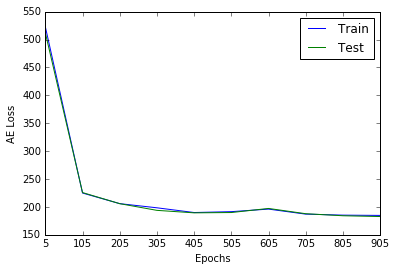

In [7]:
# saved_epochs = read_saved_epochs(conf.train_dir)
# epochs = saved_epochs[::len(saved_epochs)/10]
# stats = eval_model(vae, conf, [train_data, test_data], epochs=epochs, verbose=True)
# top_save_dir = osp.join(top_data_dir, 'OUT/model_evaluation/variational/', experiment_name)
# plot_train_val_test_curves(stats, top_save_dir, has_validation=False, best_epoch=None, show=True)

In [8]:
last_epoch = saved_epochs[-1]
vae.restore_model(conf.train_dir, last_epoch)

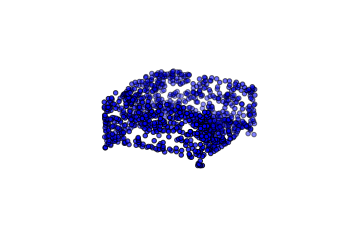

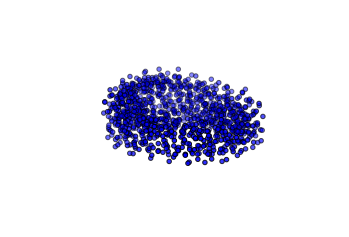

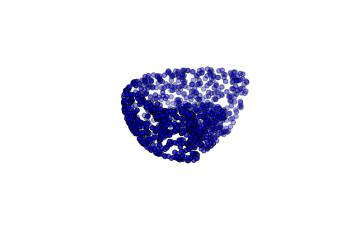

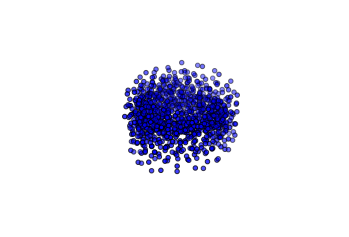

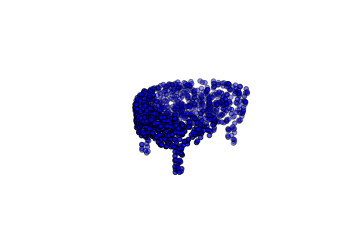

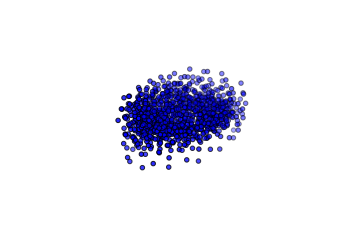

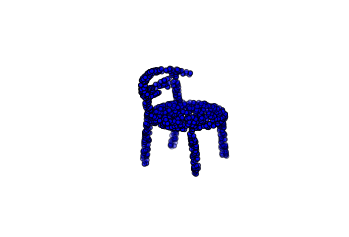

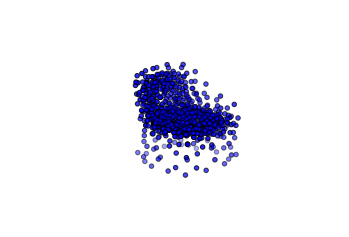

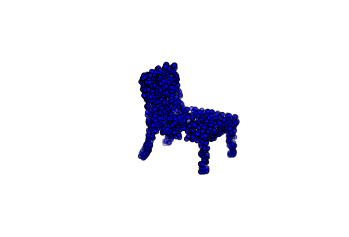

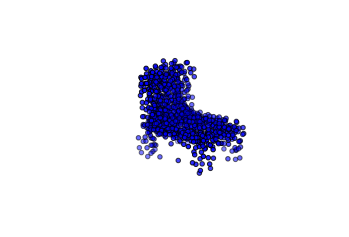

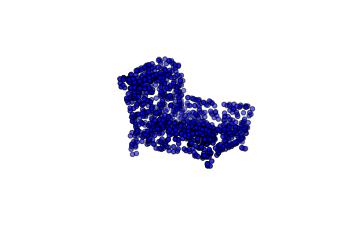

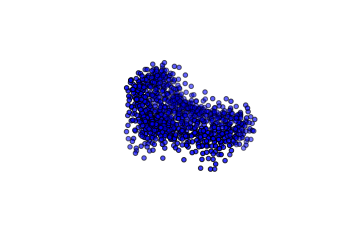

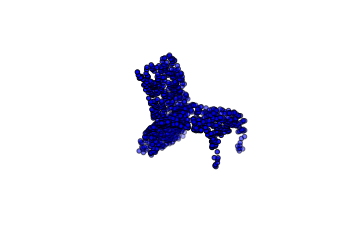

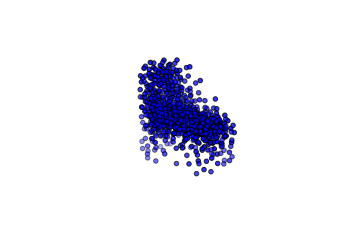

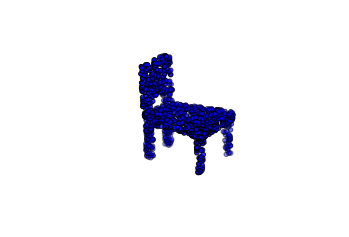

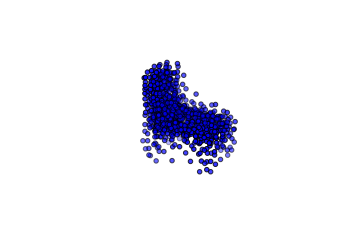

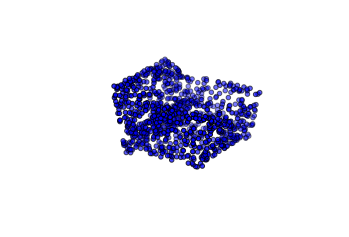

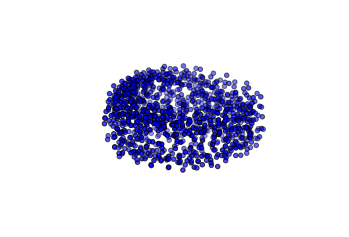

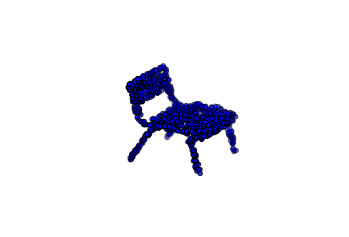

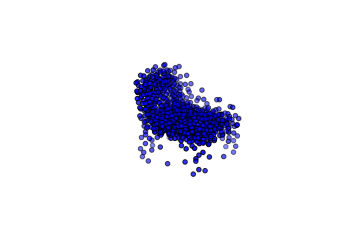

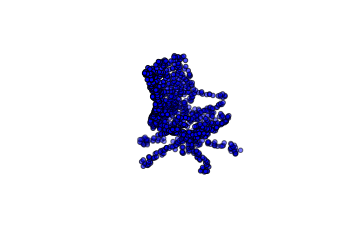

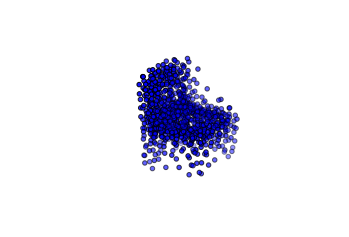

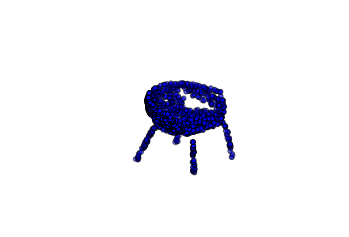

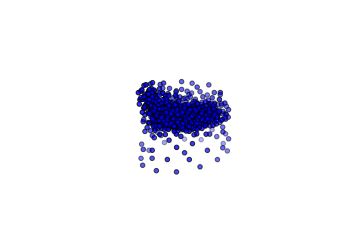

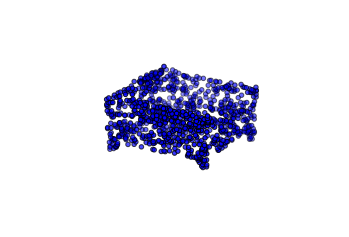

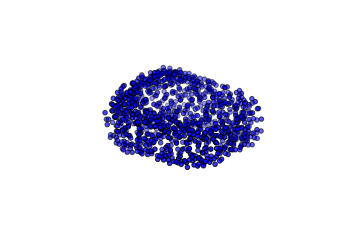

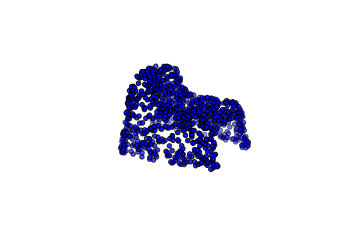

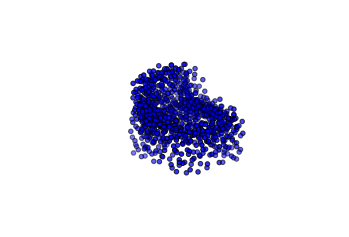

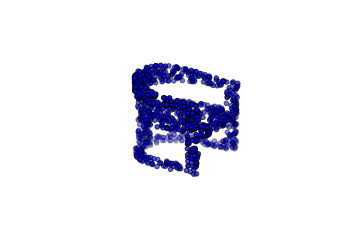

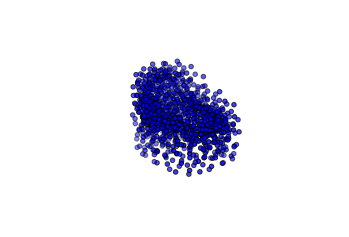

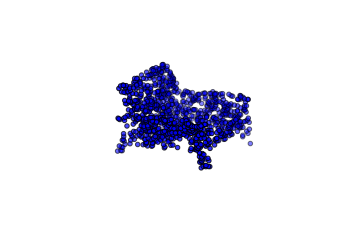

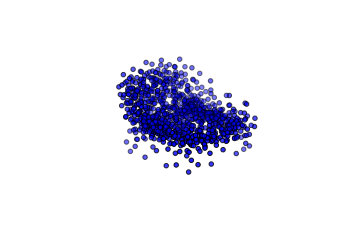

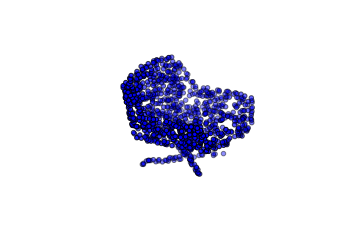

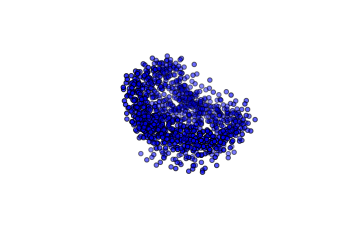

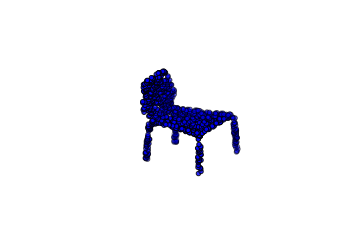

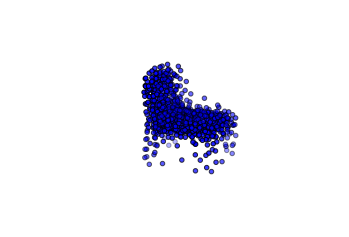

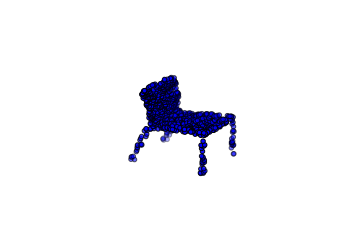

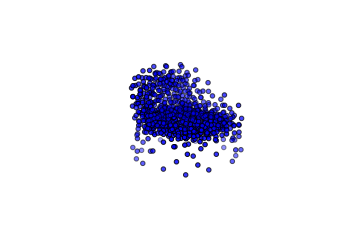

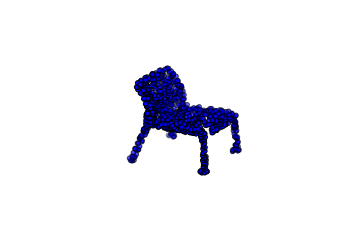

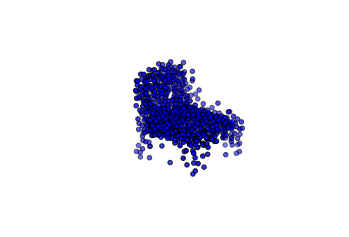

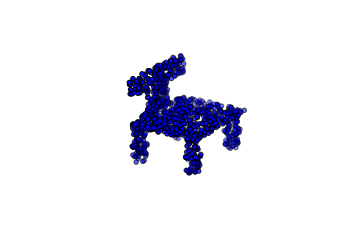

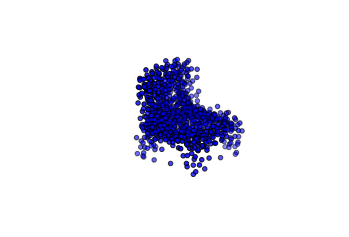

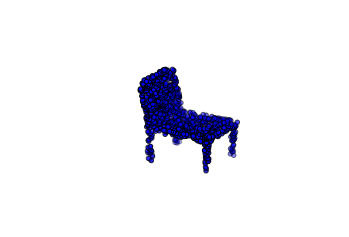

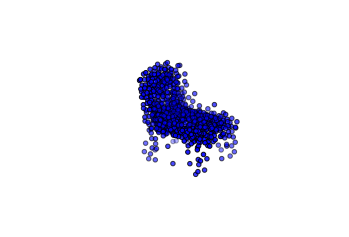

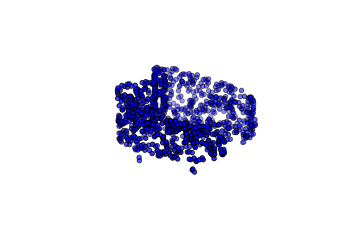

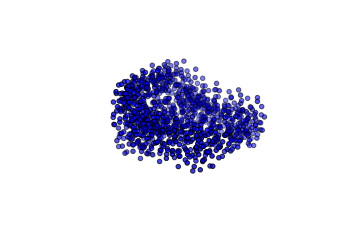

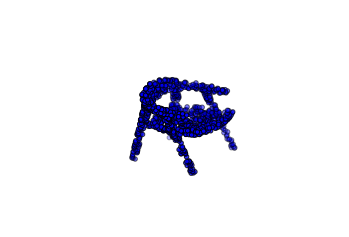

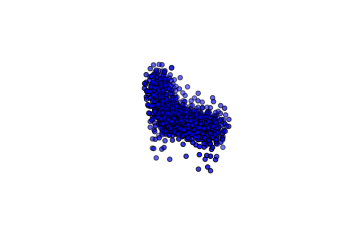

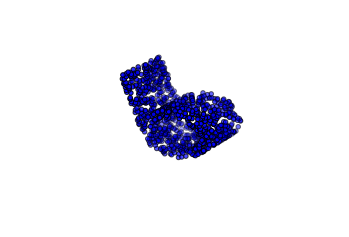

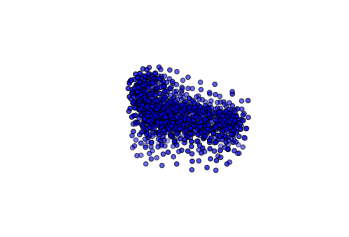

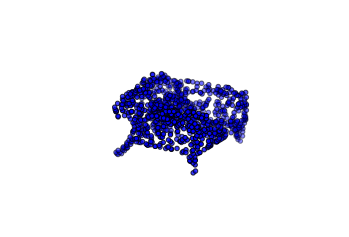

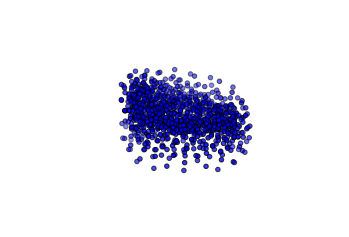

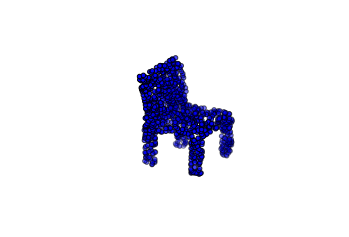

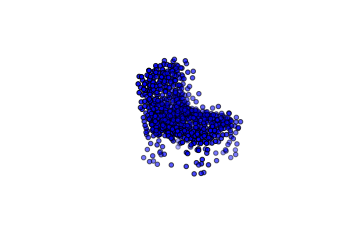

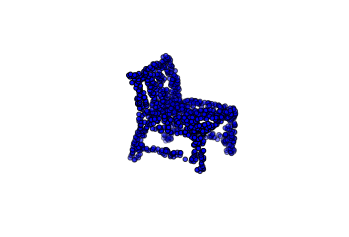

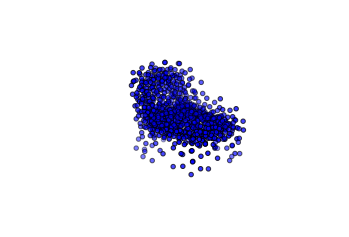

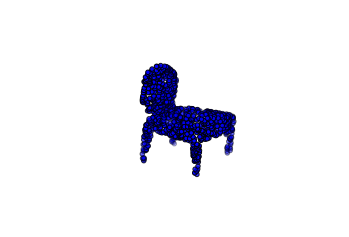

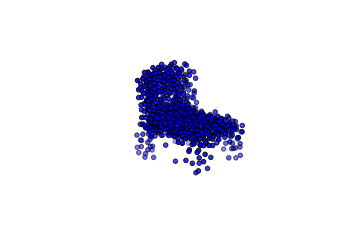

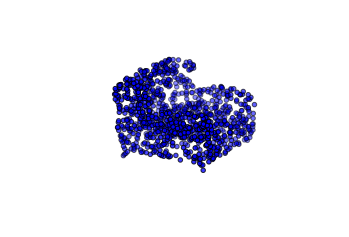

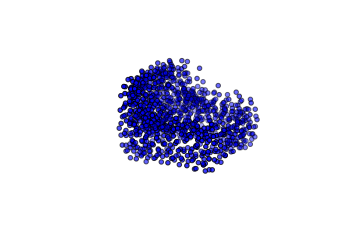

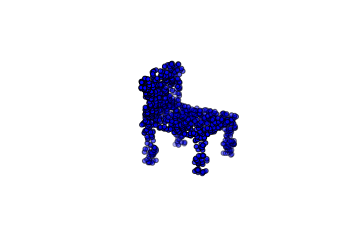

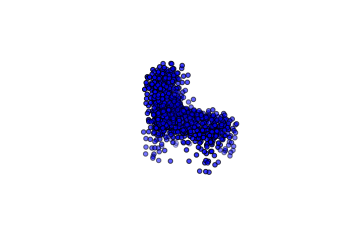

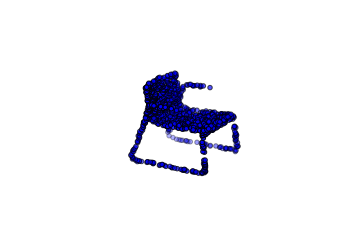

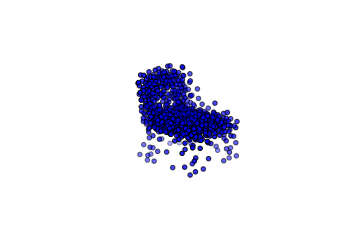

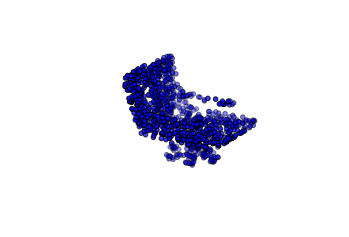

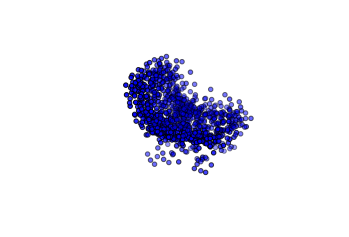

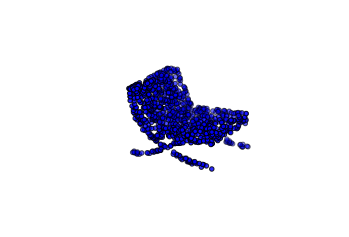

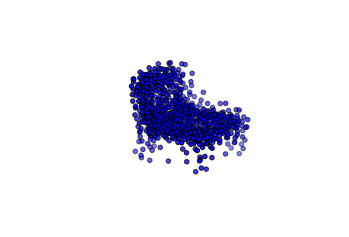

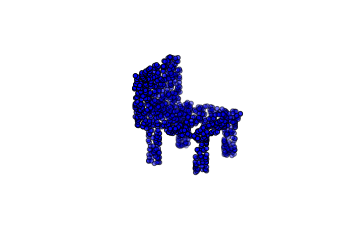

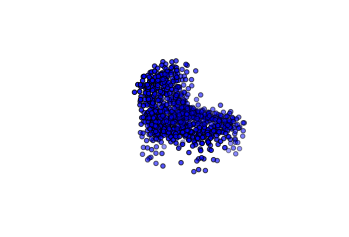

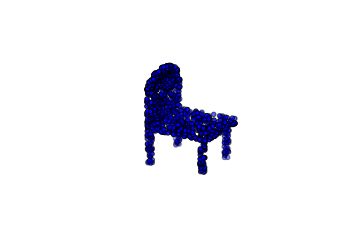

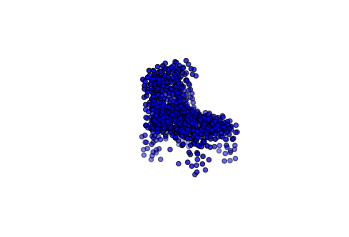

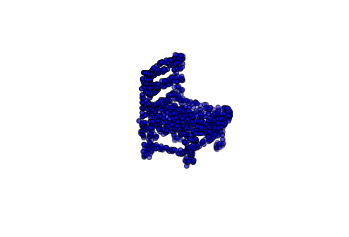

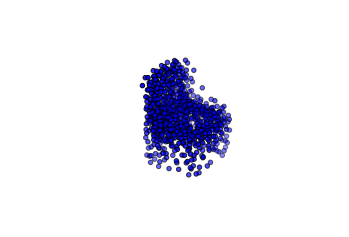

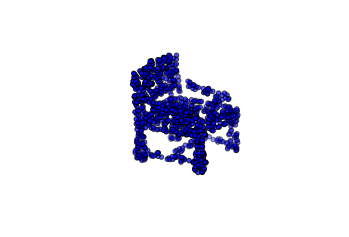

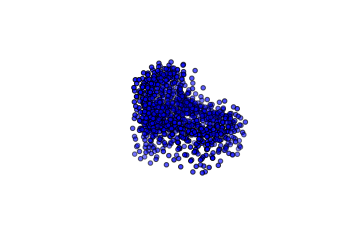

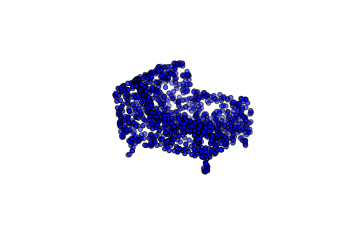

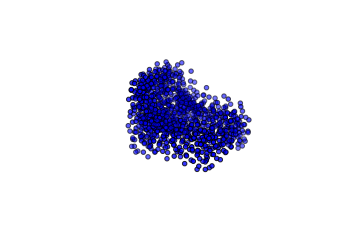

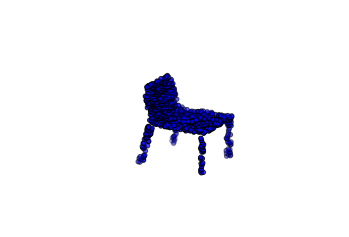

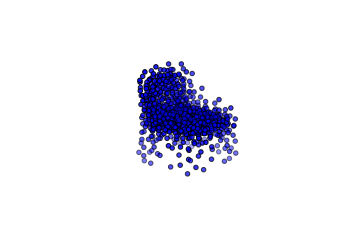

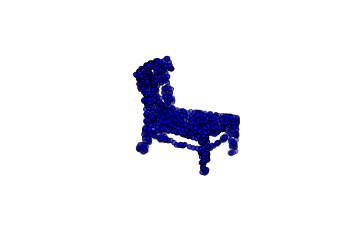

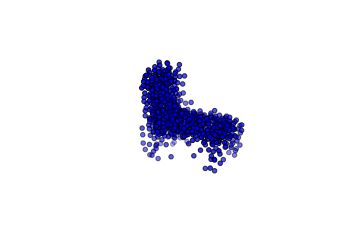

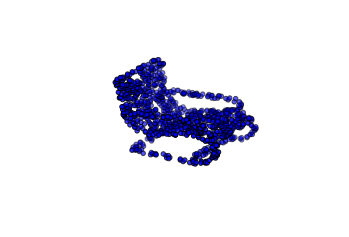

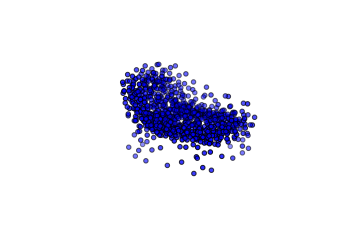

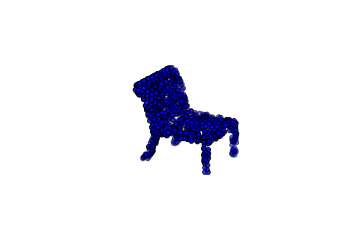

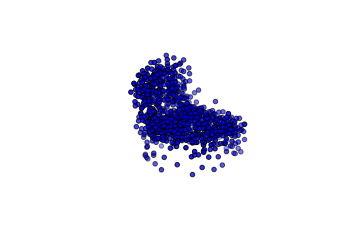

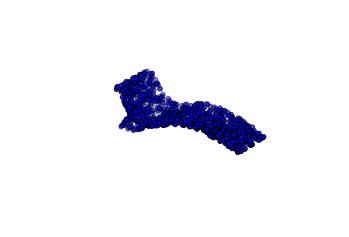

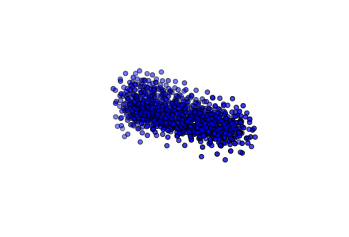

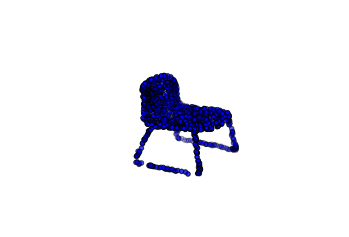

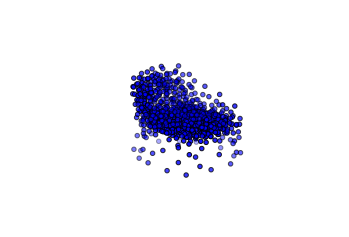

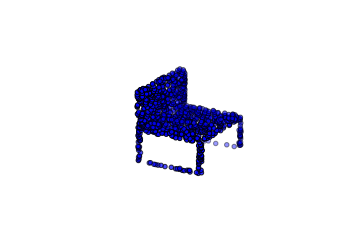

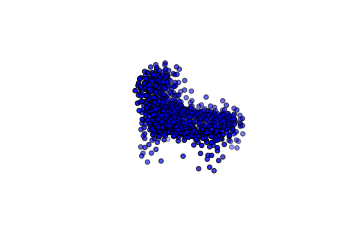

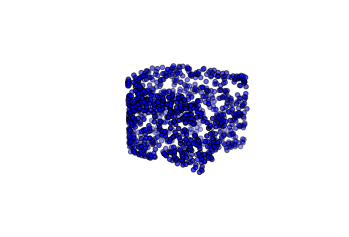

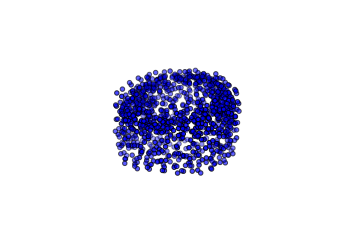

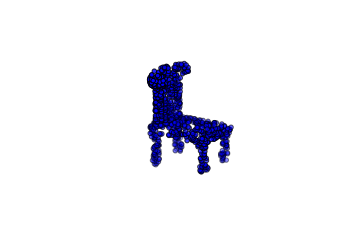

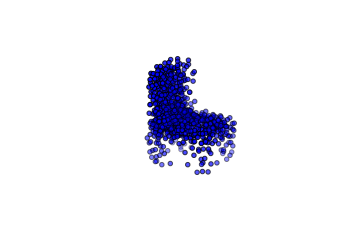

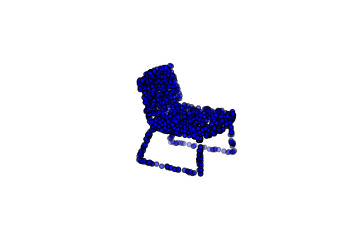

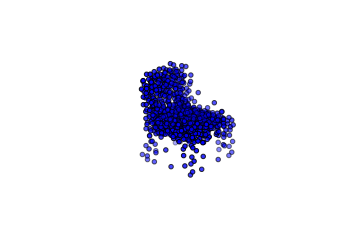

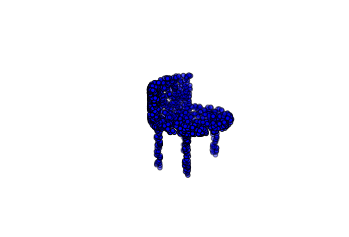

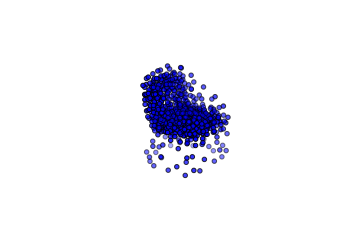

In [20]:
batch_size = conf.batch_size
feed = test_data.next_batch(batch_size)[0].reshape([batch_size] + conf.n_input)
res, loss = vae.reconstruct(feed)


loc = 1
for f,r in zip(feed, res):
    pc = Point_Cloud(points=f).center_in_unit_sphere()
#     ax = fig.add_subplot(10, 5, loc, projection='3d')    
    pc.plot(in_u_sphere=True, show=False);
    plt.axis('off')
    pc = Point_Cloud(points=r).center_in_unit_sphere()
    pc.plot(in_u_sphere=True, show=False);
    plt.axis('off')


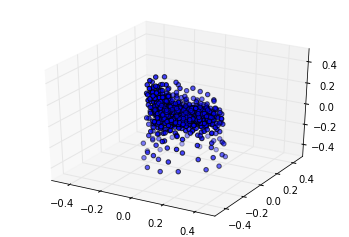

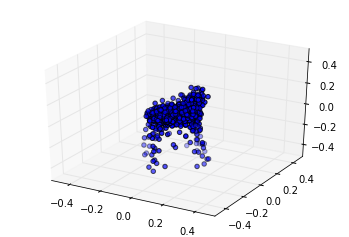

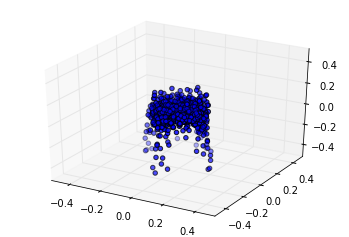

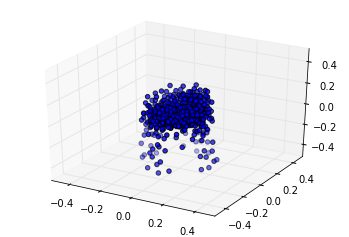

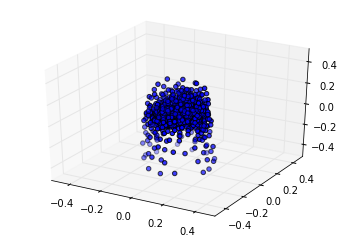

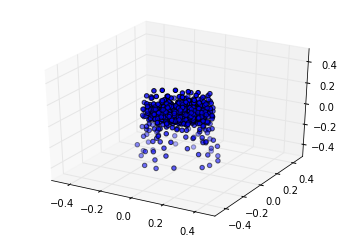

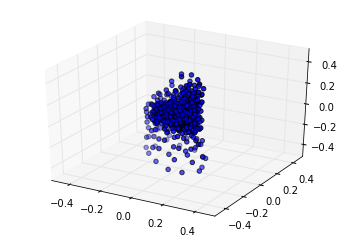

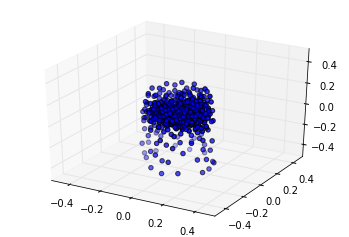

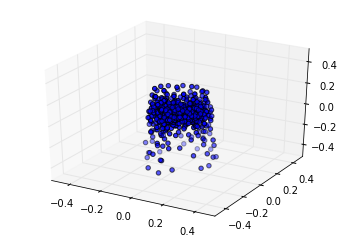

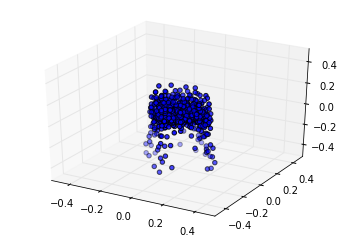

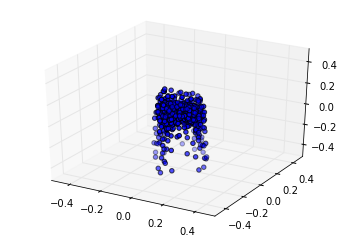

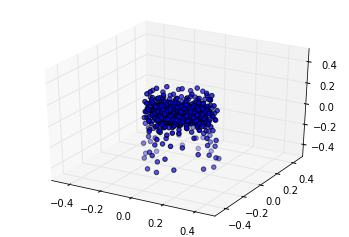

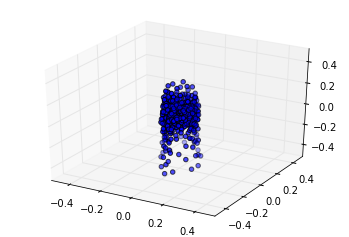

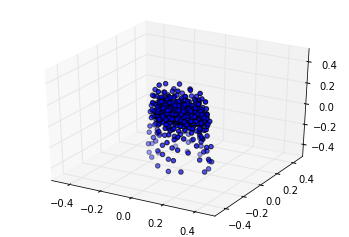

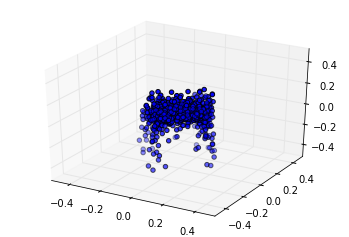

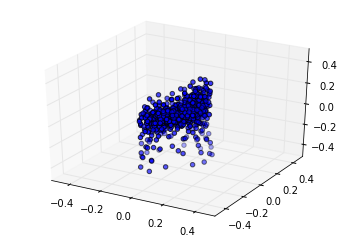

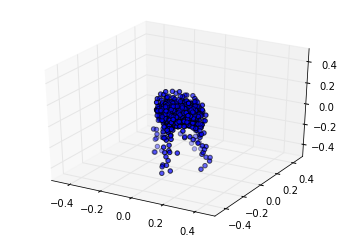

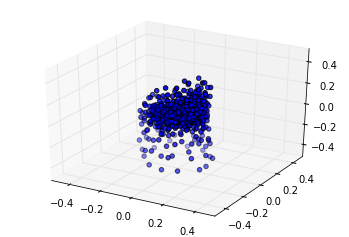

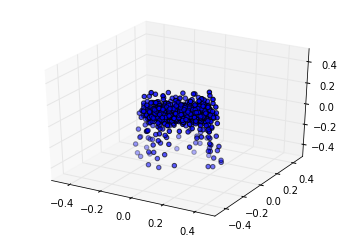

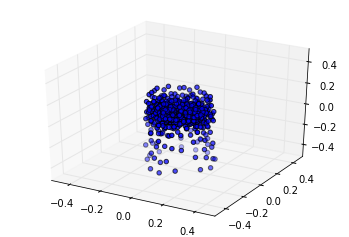

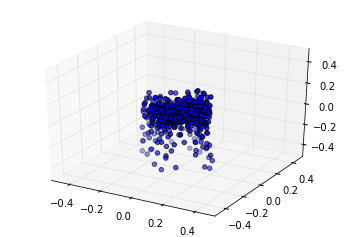

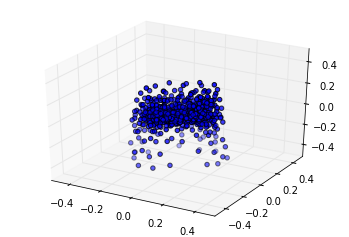

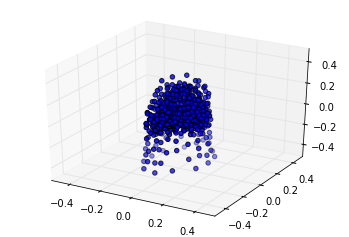

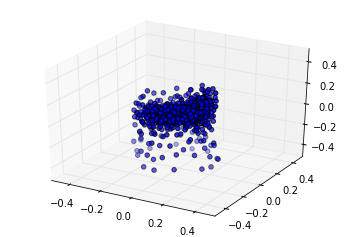

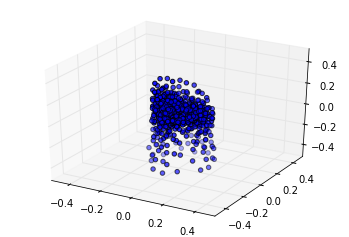

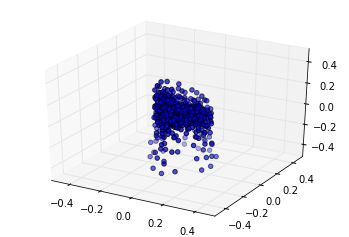

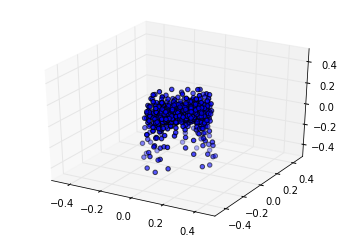

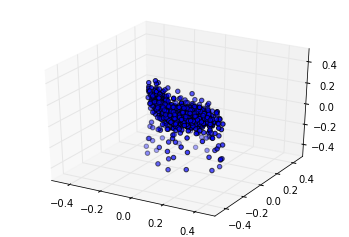

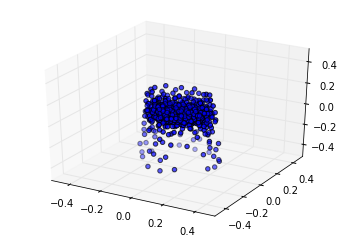

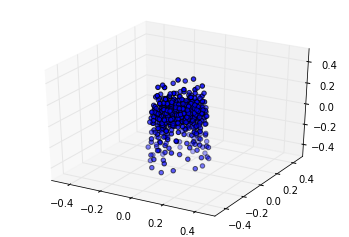

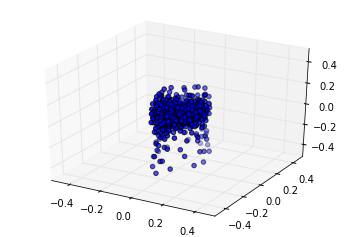

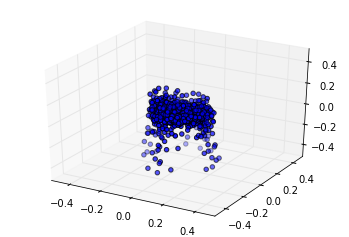

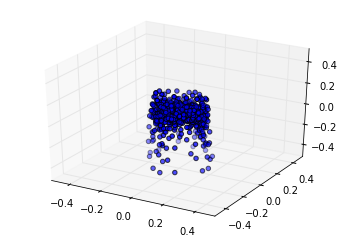

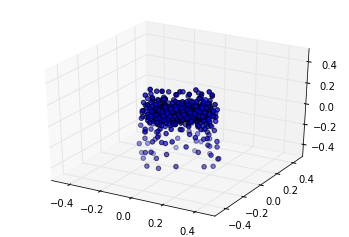

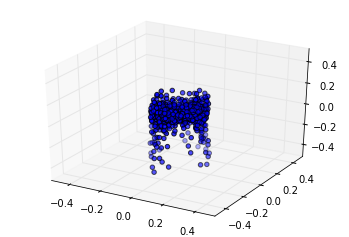

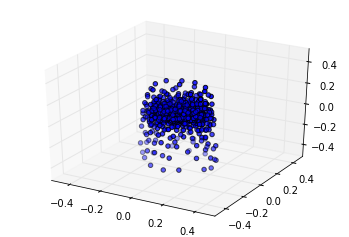

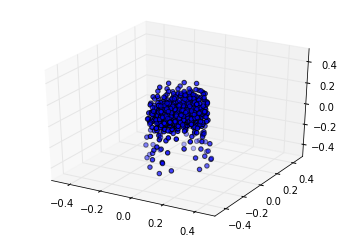

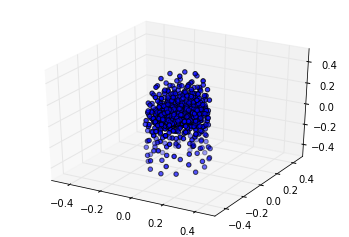

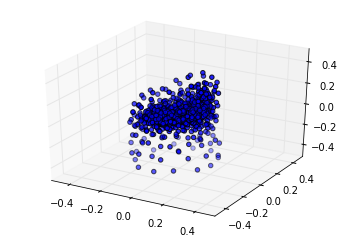

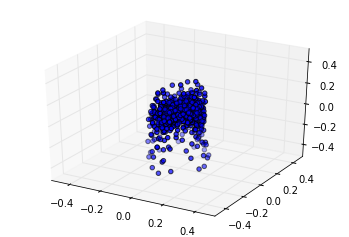

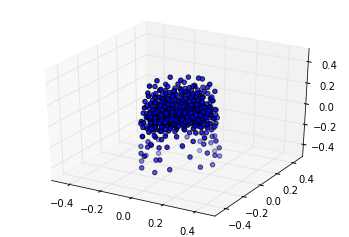

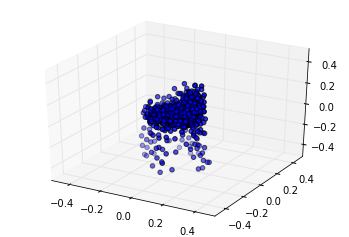

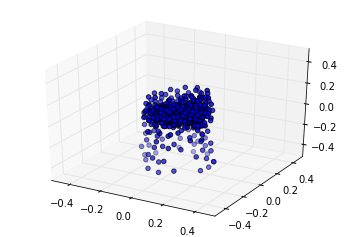

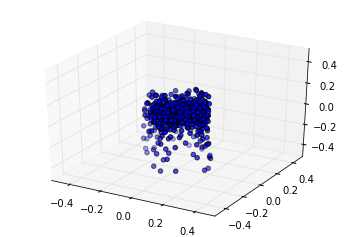

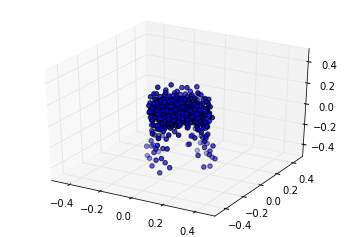

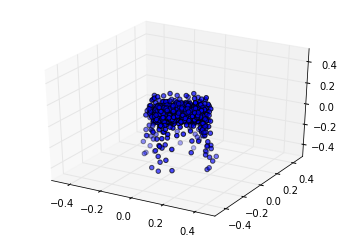

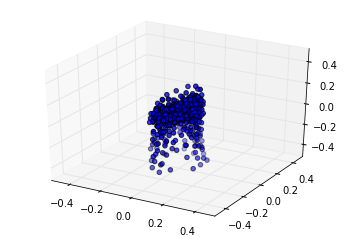

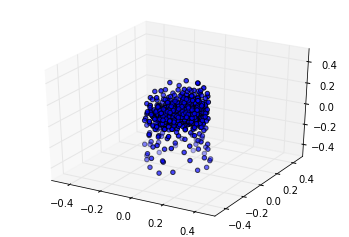

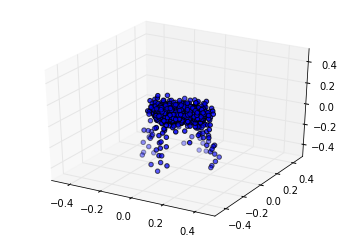

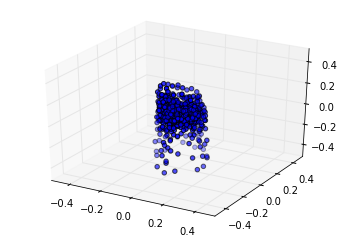

In [22]:
synthetic_data = vae.generate()
loc = 1
for p in synthetic_data:
    pc = Point_Cloud(points=p).center_in_unit_sphere()
#     ax = fig.add_subplot(10, 5, loc, projection='3d')    
    pc.plot(in_u_sphere=True, show=False);
#     plt.axis('off')